#### Análise exploratória da quantidade de ligações recebidas no call center

O objetivo desse notebook é compreender melhor por meio de conceitos relacionados à séries temporais, a base que será utilizada na construção de modelos de previsão.

#### 1. Importação das bibliotecas

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from datetime import datetime
from matplotlib.dates import DateFormatter
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime, timedelta
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss

#### 2. Importação e tratamento da base

In [2]:
#ler o arquivo já transformando a data em formato datetime
dateparse = lambda dates: datetime.strptime(dates, '%d/%m/%Y')
df = pd.read_csv('serie_temporal_teste.csv', sep = ',', parse_dates = ['DATA'], date_parser = dateparse)

In [3]:
#somar os valores das ligações por dia e horário
df1 = df.groupby(['DATA', pd.Grouper(key='Tempo')])['Ligações Recebidas', 'Ligações Atendidas'].sum()

<ipython-input-3-2de83e437335>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = df.groupby(['DATA', pd.Grouper(key='Tempo')])['Ligações Recebidas', 'Ligações Atendidas'].sum()


In [4]:
df1.head()

Ligações Recebidas  Ligações Atendidas
DATA       Tempo                                           
2021-02-01 08:00:00                   7                   7
           08:30:00                  27                  27
           09:00:00                  39                  39
           09:30:00                  50                  49
           10:00:00                  59                  59

In [5]:
#confirmando o formato dos dados
df1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6169 entries, (Timestamp('2021-02-01 00:00:00'), '08:00:00') to (Timestamp('2021-08-31 00:00:00'), '22:00:00')
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Ligações Recebidas  6169 non-null   int64
 1   Ligações Atendidas  6169 non-null   int64
dtypes: int64(2)
memory usage: 116.5+ KB


In [6]:
#tirando o index de data e horário
df1.reset_index(inplace=True)

In [7]:
#convertendo o tempo para o formato datetime
df1['Tempo'] = pd.to_datetime(df1['Tempo'], format= '%H:%M:%S')

In [8]:
#separando cada parte da data e hora em colunas diferentes
df1['Ano'] = df1['DATA'].dt.year
df1['Mês'] = df1['DATA'].dt.month
df1['Dia'] = df1['DATA'].dt.day
df1['Hora'] = df1['Tempo'].dt.hour
df1['Minutos'] = df1['Tempo'].dt.minute
df1['Segundos'] = df1['Tempo'].dt.second

In [9]:
#função para juntar todas as datas e horas correspondentes 
def processa(linha):
   # transformar as colunas desejadas em uma lista de valores inteiros:
    valores = [int(val) for val in (linha["Ano"], linha["Mês"], linha["Dia"], linha["Hora"], linha["Minutos"])]
   # criar objeto datetime:
   # O construtor do python "datetime" recebe na ordem os valores 
   # para ano, mes, dia, horas e minutos - o operador "*"
   # desempacota esses argumentos, que estão em uma lista, na chamada:
    return datetime(*valores)

# criar a série com as datas e horas:
timestamps = df1.apply(processa, axis=1)
timestamps.name = "data_hora" 

# Criar um novo dataframe com as colunas de interesse - 
# descobrir indice da coluna apos "Tempo":
remainder_start = list(df1.columns).index("Tempo")

#concatena primeiro o que foi gerado(data e hora juntos) e depois o restante das colunas
new_df = pd.concat((timestamps, df1[list(df1.columns)[remainder_start + 1: ]]), axis=1)

In [10]:
#dataframe com colunas auxiliares de minutos...
new_df.head()

,data_hora,Ligações Recebidas,Ligações Atendidas,Ano,Mês,Dia,Hora,Minutos,Segundos
0,2021-02-01 08:00:00,7,7,2021,2,1,8,0,0
1,2021-02-01 08:30:00,27,27,2021,2,1,8,30,0
2,2021-02-01 09:00:00,39,39,2021,2,1,9,0,0
3,2021-02-01 09:30:00,50,49,2021,2,1,9,30,0
4,2021-02-01 10:00:00,59,59,2021,2,1,10,0,0


In [11]:
#excluindo todas as colunas adicionais já que não vamos utilizar elas
new_df.drop(columns=['Ano', 'Mês', 'Dia', 'Hora', 'Minutos', 'Segundos'], inplace=True)

In [47]:
new_df.to_excel('base_pronta.xlsx')

In [12]:
#confirmando se data_hora está em datetime
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6169 entries, 0 to 6168
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data_hora           6169 non-null   datetime64[ns]
 1   Ligações Recebidas  6169 non-null   int64         
 2   Ligações Atendidas  6169 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 144.7 KB


In [13]:
#verificando se o df possui algum index já
new_df.index

RangeIndex(start=0, stop=6169, step=1)

In [14]:
#indexando a coluna df para utilização no time series
new_df.set_index('data_hora', inplace=True)

In [15]:
new_df.index

DatetimeIndex(['2021-02-01 08:00:00', '2021-02-01 08:30:00',
               '2021-02-01 09:00:00', '2021-02-01 09:30:00',
               '2021-02-01 10:00:00', '2021-02-01 10:30:00',
               '2021-02-01 11:00:00', '2021-02-01 11:30:00',
               '2021-02-01 12:00:00', '2021-02-01 12:30:00',
               ...
               '2021-08-31 17:30:00', '2021-08-31 18:00:00',
               '2021-08-31 18:30:00', '2021-08-31 19:00:00',
               '2021-08-31 19:30:00', '2021-08-31 20:00:00',
               '2021-08-31 20:30:00', '2021-08-31 21:00:00',
               '2021-08-31 21:30:00', '2021-08-31 22:00:00'],
              dtype='datetime64[ns]', name='data_hora', length=6169, freq=None)

In [16]:
#verificando o df depois do tratamento 
new_df.head()

,Ligações Recebidas,Ligações Atendidas
data_hora,,
2021-02-01 08:00:00,7,7
2021-02-01 08:30:00,27,27
2021-02-01 09:00:00,39,39
2021-02-01 09:30:00,50,49
2021-02-01 10:00:00,59,59


In [18]:
#renomeando colunas para remover espaços e acentos
new_df.rename(columns={'Ligações Recebidas': 'ligacoes_recebidas', 'Ligações Atendidas': 'ligacoes_atendidas'}, inplace=True)

In [20]:
new_df.loc[(new_df['ligacoes_recebidas'] == 0)]

#por causa disso, não é possível utilizar o método da multiplicação, a não ser que esses valores sejam substituídos, o que comprometeria a análise

,ligacoes_recebidas,ligacoes_atendidas
data_hora,,
2021-03-04 22:30:00,0,0
2021-03-10 22:30:00,0,0
2021-03-19 23:30:00,0,0
2021-06-06 08:30:00,0,0
2021-07-11 08:00:00,0,0
2021-07-18 22:00:00,0,0
2021-07-25 08:00:00,0,0
2021-07-25 11:00:00,0,0
2021-07-30 08:00:00,0,0


array([[<AxesSubplot:title={'center':'ligacoes_recebidas'}>,
        <AxesSubplot:title={'center':'ligacoes_atendidas'}>]],
      dtype=object)

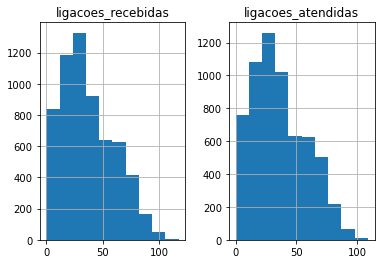

In [59]:
new_df.hist()

In [21]:
#criação da série temporal ts
ts = new_df['ligacoes_recebidas']
ts

data_hora
2021-02-01 08:00:00     7
2021-02-01 08:30:00    27
2021-02-01 09:00:00    39
2021-02-01 09:30:00    50
2021-02-01 10:00:00    59
                       ..
2021-08-31 20:00:00    35
2021-08-31 20:30:00    23
2021-08-31 21:00:00    24
2021-08-31 21:30:00    19
2021-08-31 22:00:00     5
Name: ligacoes_recebidas, Length: 6169, dtype: int64

In [22]:
#visualização de uma data e horário específico
ts[datetime(2021,2,1, 8, 30)]

27

In [23]:
# Visualização de intervalos
ts['2021-02-01 08:00:00':'2021-02-01 22:00:00']

data_hora
2021-02-01 08:00:00     7
2021-02-01 08:30:00    27
2021-02-01 09:00:00    39
2021-02-01 09:30:00    50
2021-02-01 10:00:00    59
2021-02-01 10:30:00    68
2021-02-01 11:00:00    57
2021-02-01 11:30:00    82
2021-02-01 12:00:00    72
2021-02-01 12:30:00    64
2021-02-01 13:00:00    67
2021-02-01 13:30:00    86
2021-02-01 14:00:00    63
2021-02-01 14:30:00    75
2021-02-01 15:00:00    76
2021-02-01 15:30:00    72
2021-02-01 16:00:00    66
2021-02-01 16:30:00    70
2021-02-01 17:00:00    59
2021-02-01 17:30:00    51
2021-02-01 18:00:00    51
2021-02-01 18:30:00    56
2021-02-01 19:00:00    53
2021-02-01 19:30:00    46
2021-02-01 20:00:00    47
2021-02-01 20:30:00    41
2021-02-01 21:00:00    39
2021-02-01 21:30:00    25
2021-02-01 22:00:00    15
Name: ligacoes_recebidas, dtype: int64

In [24]:
# Visualização por ano
ts['2021']

data_hora
2021-02-01 08:00:00     7
2021-02-01 08:30:00    27
2021-02-01 09:00:00    39
2021-02-01 09:30:00    50
2021-02-01 10:00:00    59
                       ..
2021-08-31 20:00:00    35
2021-08-31 20:30:00    23
2021-08-31 21:00:00    24
2021-08-31 21:30:00    19
2021-08-31 22:00:00     5
Name: ligacoes_recebidas, Length: 6169, dtype: int64

#### 3. Análise exploratória 

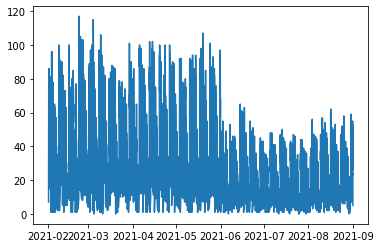

In [25]:
# Visualização da série temporal completa
plt.plot(ts)

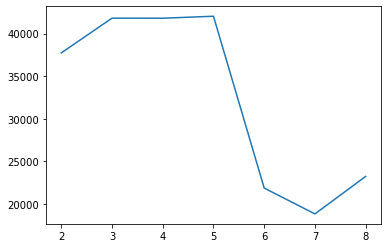

In [26]:
# Visualização por mês
ts_mes = ts.groupby([lambda x: x.month]).sum()
plt.plot(ts_mes)

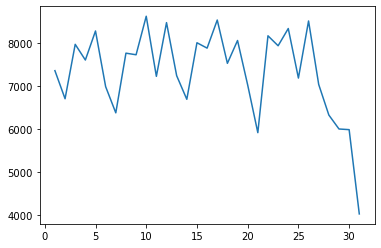

In [27]:
# Visualização por dia
ts_dia = ts.groupby([lambda x: x.day]).sum()
plt.plot(ts_dia)

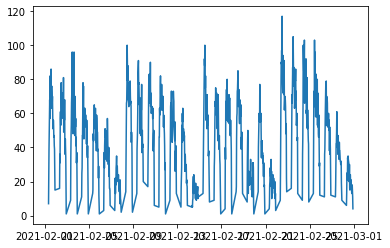

In [28]:
# Visualização dos valores somente de fevereiro
ts_fev = ts['2021-02-01 08:00:00':'2021-02-28 22:00:00']
plt.plot(ts_fev)

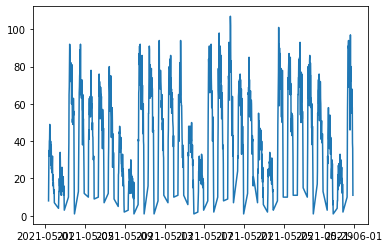

In [29]:
# Visualização dos valores somente de maio
ts_maio = ts['2021-05-01 08:00:00':'2021-05-31 22:00:00']
plt.plot(ts_maio)

#pico no final do mês diferente da tendência observada nos meses anteriores

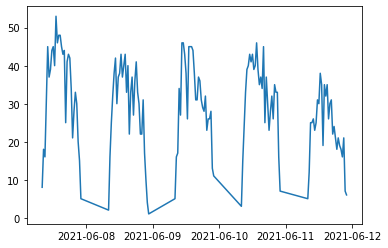

In [30]:
#visualização dos valores de 1 semana específica de junho
ts_jun1 = ts['2021-06-07 08:00:00':'2021-06-11 22:00:00']
plt.plot(ts_jun1)

#monthly and weekly seasonality

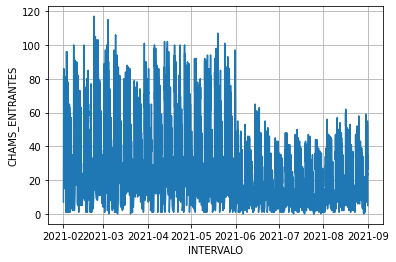

In [31]:
# plotar gráfico da série completa
plt.plot(new_df.index, new_df.ligacoes_recebidas)
plt.xlabel('INTERVALO', fontsize = 10)
plt.ylabel('CHAMS_ENTRANTES',fontsize = 10)
plt.grid()

#aqui já da para perceber se a série é estacionária ou não 
#analisar presença de tendência (mudanças na média) - existe tendência (diminuição do volume de ligações a partir de junho)
#sazonalidade, qual período possui mais ligações - sempre início da semana, últimos horários do dia o valor tende a cair

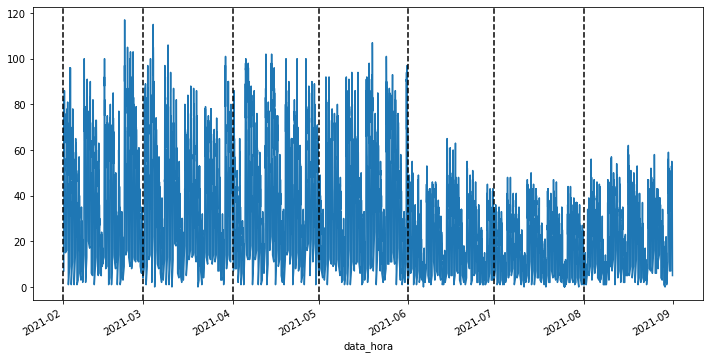

In [32]:
#gráfico plotado com linhas demarcando o início e final de cada mês
ax = ts.plot(x='data', y='ligacoes_recebidas', figsize=(12,6))
xcoords = ['2021-02-01', '2021-03-01','2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
          '2021-08-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

#### 4. Decomposição

In [76]:
# Decomposição da série temporal, criando uma variável para cada formato
decomposicao = seasonal_decompose(ts, period=33, extrapolate_trend='freq')

In [77]:
tendencia = decomposicao.trend
tendencia

data_hora
2021-02-01 08:00:00    59.156107
2021-02-01 08:30:00    58.971706
2021-02-01 09:00:00    58.787305
2021-02-01 09:30:00    58.602904
2021-02-01 10:00:00    58.418503
                         ...    
2021-08-31 20:00:00    38.225085
2021-08-31 20:30:00    38.294118
2021-08-31 21:00:00    38.363150
2021-08-31 21:30:00    38.432183
2021-08-31 22:00:00    38.501215
Name: trend, Length: 6169, dtype: float64

In [78]:
sazonal = decomposicao.seasonal
sazonal

data_hora
2021-02-01 08:00:00   -0.123146
2021-02-01 08:30:00   -0.474777
2021-02-01 09:00:00   -0.009684
2021-02-01 09:30:00    0.568194
2021-02-01 10:00:00    0.169083
                         ...   
2021-08-31 20:00:00    0.530350
2021-08-31 20:30:00    0.083700
2021-08-31 21:00:00    0.855815
2021-08-31 21:30:00    0.713006
2021-08-31 22:00:00    1.296496
Name: seasonal, Length: 6169, dtype: float64

In [79]:
aleatorio = decomposicao.resid
aleatorio

data_hora
2021-02-01 08:00:00   -52.032961
2021-02-01 08:30:00   -31.496929
2021-02-01 09:00:00   -19.777621
2021-02-01 09:30:00    -9.171098
2021-02-01 10:00:00     0.412414
                         ...    
2021-08-31 20:00:00    -3.755435
2021-08-31 20:30:00   -15.377818
2021-08-31 21:00:00   -15.218965
2021-08-31 21:30:00   -20.145188
2021-08-31 22:00:00   -34.797712
Name: resid, Length: 6169, dtype: float64

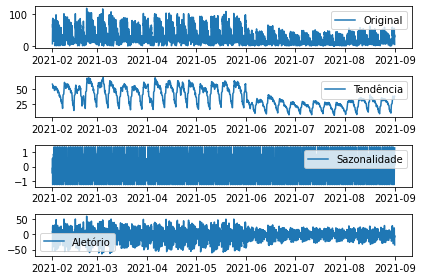

In [80]:
plt.subplot(4,1,1)
plt.plot(ts, label = 'Original')
plt.legend(loc = 'best')

# Visualização somente da tendência
plt.subplot(4,1,2)
plt.plot(tendencia, label = 'Tendência')
plt.legend(loc = 'best')

# Visualização somente da sazonalidade (flutuações periódicas) - 
# ela está assim pq a sazonalidade é diária, então o gráfico fica 'apertado' para mostrar essa flutuação
plt.subplot(4,1,3)
plt.plot(sazonal, label = 'Sazonalidade')
plt.legend(loc = 'best')

# Visualização somente do elemento aleatório
plt.subplot(4,1,4)
plt.plot(aleatorio, label = 'Aletório')
plt.legend(loc = 'best')
plt.tight_layout()

#### 5. Teste de estacionariedade

- H0: a base de dados é não estacionária
- H1: a base de dados é estacionária

Rejeição de H0: p-value menor que 0.05

Quanto mais negativo o valor de ADF, maior é a probabilidade de rejeitar H0

In [65]:
X = new_df['ligacoes_recebidas']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %.20f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.065782
p-value: 0.00000000000000443682
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [54]:
#testando a estacinariedade de Fuller 
test_estacionariedade = adfuller(new_df['ligacoes_recebidas'])
output = pd.Series(test_estacionariedade[0:4], index = ['Teste', 'p-valor','Lags','Número de observações usadas'])

for key, value in test_estacionariedade[4].items():
    output['Valor crítico(%s)' %key] = value
print(output)

#serie estacionária

Teste                          -9.065782e+00
p-valor                         4.436821e-15
Lags                            3.300000e+01
Número de observações usadas    6.135000e+03
Valor crítico(1%)              -3.431416e+00
Valor crítico(5%)              -2.862011e+00
Valor crítico(10%)             -2.567021e+00
dtype: float64


#### 6. Teste KPSS

- H0: a série é estacionária
- H1: a série é não estacionária

Rejeição de H0: p-value menor que 0.05

In [87]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(ts)

KPSS Statistic: 7.178157505969207
p-value: 0.01
num lags: 34
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\Users\42220_sarah\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


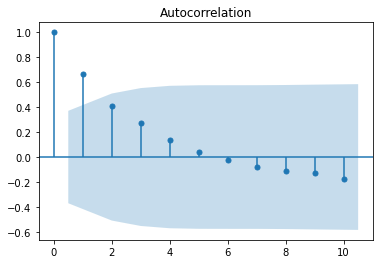

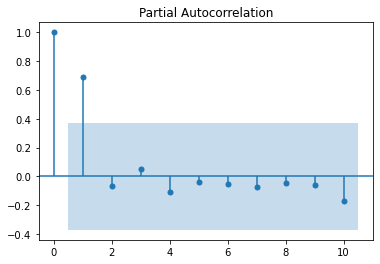

In [27]:
# Verificando as funções ACF e PACF
acf = plot_acf(df['CHAMS_ENTRANTES'], lags = 10)
pacf = plot_pacf(df['CHAMS_ENTRANTES'], lags = 10)